In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor

# 1. 데이터 전처리

In [2]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','이완기혈압']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','dbp']

df = df.dropna(axis = 0)

df['bmi'] = df['wt'] / ((df['ht']/100)**2)
df['absi'] = (df['waist']*0.393701) /((df['bmi']**0.6666) * ((df['ht']/100)**0.5))
df = df.round(decimals = 2)

df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55.0)].index, inplace = True)
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)



# 2. 모델링

## 1) Linear Regression

In [3]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['dbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse_LR = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_LR)

rmse :  9.264237031110188


In [10]:
X_test.loc[[703231]]
y_test[703231]

70.0

## 2) Polynomial Linear Regression_2차

In [6]:
## 2. polynomialFeatures(degree=2)

poly_train = PolynomialFeatures(degree=2).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=2).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse_PLR2 = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_PLR2) 

rmse :  9.20479191462278


## 3) Polynomial Linear Regression_3차

In [7]:
## 2. polynomialFeatures(degree=3)

poly_train = PolynomialFeatures(degree=3).fit_transform(X_train)


## 3. Linear Regression 

PLR3 = LinearRegression()
PLR3.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=3).fit_transform(X_test)
y_hat = PLR3.predict(poly_test)

## 5. RMSE

rmse_PLR3 = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_PLR3)  

rmse :  9.185628475612518


## 4) Ridge Regression

In [8]:
## 2. model define

ridge = Ridge(alpha = 0.05)
ridge.fit(X_train, y_train)
y_hat = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_ridge)  

rmse :  9.26423705015516


## 5) Lasso Regression

In [9]:
## 2. model define
    
lasso = Lasso(alpha = 0.05)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_lasso) 

rmse :  9.269692752726437


## 6) ElasticNet Regression 

In [10]:
elastic = ElasticNet(alpha = 0.05, l1_ratio=0.7)
elastic.fit(X_train, y_train)
y_hat = elastic.predict(X_test)
rmse_elasticNet = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_elasticNet) 

rmse :  9.270205875032802


## 7) Decision Tree

In [11]:
## 2. fit 

dt = DecisionTreeRegressor(random_state = 2045, max_depth = 8  ,min_samples_split = 128)
dt.fit(X_train, y_train)

## 3. Predict

y_hat = dt.predict(X_test)

## 4. Root MSE 

rmse_dt = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_dt)


rmse :  9.213507489091224


## 8) RandomForest

In [12]:
%%time

## 2. fit 

rf = RandomForestRegressor(random_state = 2045, max_depth = 10  ,max_features = 4, n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)

## 3. Predict

y_hat = rf.predict(X_test)

## 4. Root MSE 

rmse_rf = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_rf)


rmse :  9.191027144565261
Wall time: 12.3 s


## 9) GradientBoosting Regression

In [13]:
%%time

## 2. fit 

gb = GradientBoostingRegressor(random_state = 2045, n_estimators = 1000, learning_rate = 0.03)
gb.fit(X_train, y_train)

## 3. Predict

y_hat = gb.predict(X_test)

## 4. Root MSE 

rmse_GBM = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_GBM)


rmse :  9.182979828259672
Wall time: 8min 45s


## 10) XGBoost_gbtree

In [14]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045, 
                    n_estimators = 1000, 
                    learning_rate = 0.01,
                   max_depth = 10)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse_XGBtree = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_XGBtree)


rmse :  9.195599273446149
Wall time: 3min 40s


## 11) XGBoost_gblinear

In [16]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045,
                   booster = 'gblinear',
                    n_estimators = 2000, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse_XGBlinear = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_XGBlinear)



rmse :  9.288525596977223
Wall time: 26.7 s


## 12) LGBM Regression 

In [4]:
%%time

## 2. fit 

lgb = LGBMRegressor(random_state = 2045,
                    n_estimators = 2000, 
                    learning_rate = 0.01,
                  max_depth = 12)
lgb.fit(X_train, y_train)

## 3. Predict

y_hat = lgb.predict(X_test)

error = y_test - y_hat

print('max_error : ', np.max(abs(error)))
print('min_error : ', np.min(abs(error)))

## 4. Root MSE 

rmse_LGBM = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_LGBM)



max_error :  102.16819167168133
min_error :  1.7683073096463886e-05
rmse :  9.181909564565064
Wall time: 27.5 s


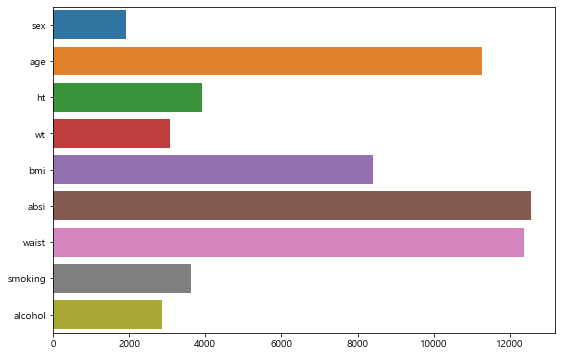

In [5]:
plt.figure(figsize = (9,6))
sns.barplot(lgb.feature_importances_,
           X_train.columns)
plt.savefig('featureImportance_dbp.png')
plt.show()

In [7]:
pickle.dump(lgb, open('LGBM_DBP.sav', 'wb'))

## 13) MLP Regression 

In [19]:
%%time 

## 2. model define & fit

mlp = MLPRegressor(hidden_layer_sizes = (128,128,64), activation = 'relu', random_state = 2045,
                  max_iter = 2000)
mlp.fit(X_train, y_train)

## 3. predicition

y_hat = mlp.predict(X_test)

## 4. RMSE, R2 score

rmse_MLP2 = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse_MLP2)

rmse :  9.200935680978372
Wall time: 23min 21s


# 3. 모델 Selection

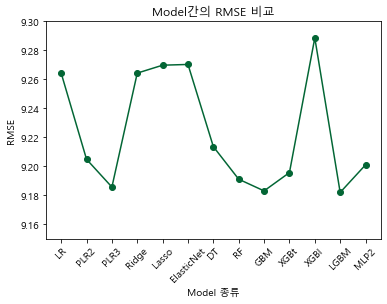

In [22]:
name = ['LR','PLR2','PLR3','Ridge','Lasso','ElasticNet','DT','RF','GBM','XGBt','XGBl','LGBM','MLP2']
rmses = [rmse_LR, rmse_PLR2, rmse_PLR3, rmse_ridge, rmse_lasso, rmse_elasticNet, 
        rmse_dt, rmse_rf, rmse_GBM, rmse_XGBtree, rmse_XGBlinear, rmse_LGBM, rmse_MLP2 ]


plt.figsize = (20, 10)
plt.plot(name, rmses, marker = 'o' , color = '#036635')
plt.ylim(9.15,9.30)
plt.xticks(rotation = 45)
plt.xlabel('Model 종류')
plt.ylabel('RMSE')
plt.title('Model간의 RMSE 비교')
plt.savefig('rmse_Models.png')
plt.show()

In [24]:
print('max : ', np.max(rmses))
print('min : ', np.min(rmses))

max :  9.288525596977223
min :  9.181909564565064


In [26]:
rmses[-2]

9.181909564565064